# import prerequisite

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer

# function

## 1. function(Make a function for create a Data Frame as df.info *)

In [2]:
def info_data_frame(data_frame:pd.DataFrame):
    columns=data_frame.columns
    columns=list(columns)
    df_info=pd.DataFrame(data=columns,columns=["Column"])
    not_null=list()
    Dtypes=list()
    Max=list()
    Min=list()
    for column in data_frame.columns:
        not_null.append((~data_frame[column].isna()).sum())
        Dtypes.append(data_frame[column].dtype)
        Max.append(data_frame[column].max())
        Min.append(data_frame[column].min())
    df_info["notNull"]=not_null
    df_info["Dtype"]=Dtypes
    df_info["Max"]=Max
    df_info["Min"]=Min
    return df_info

## 2. function (find null value in each rows)

In [3]:
def find_isna(data_frame:pd.DataFrame,Condition:int = 0):
    list_isna=list()
    for row_index in range(len(data_frame)-1):
        if data_frame.iloc[row_index].isna().sum()>=Condition:
            list_isna.append(data_frame.iloc[row_index].isna().sum())
    value_data_frame=pd.DataFrame(data=list_isna,columns=["isna"]).reset_index()
    return value_data_frame

## 3. function (Skewness handing)

In [23]:
def visualize_numerical_distributions(df, exclude_columns='id'):

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numeric_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a histogram with KDE
    for i, col in enumerate(numeric_columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

## 3. function (Skewness handing)

In [28]:
from scipy import stats

def robust_skewness_handler(df, threshold=2.0):
    transformed_df = df.copy()
    transformation_dict = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        data = df[col].dropna()
        skewness = data.skew()

        if abs(skewness) > threshold:
            print(f"Handling skewness for {col} (skewness: {skewness:.2f})")

            # Handle zero-inflated or near-zero-inflated data
            if (data == 0).sum() / len(data) > 0.1:  # If more than 10% zeros
                non_zero = data[data != 0]
                if len(non_zero) > 0:
                    log_transform = np.log1p(non_zero)
                    transformed_df.loc[data != 0, col] = log_transform
                    transformation_dict[col] = ('log1p', 'zero-inflated')
                    print(f"  Applied Log1p to non-zero values for {col}")
                continue

            # Try Box-Cox transformation
            min_val = data.min()
            if min_val <= 0:
                shift = abs(min_val) + 1
                shifted_data = data + shift
            else:
                shifted_data = data

            try:
                transformed_data, lambda_param = stats.boxcox(shifted_data)
                transformed_df[col] = transformed_data
                transformation_dict[col] = ('box-cox', lambda_param)
                print(f"  Applied Box-Cox to {col} (lambda: {lambda_param:.2f})")
            except:
                # If Box-Cox fails, try other transformations
                if skewness > 0:  # Right-skewed
                    if data.max() / data.min() > 1000:  # Very large range
                        transformed_df[col] = np.log1p(data)
                        transformation_dict[col] = ('log1p', None)
                        print(f"  Applied Log1p to {col}")
                    else:
                        transformed_df[col] = np.sqrt(data)
                        transformation_dict[col] = ('sqrt', None)
                        print(f"  Applied Square Root to {col}")
                else:  # Left-skewed
                    transformed_df[col] = data ** 2
                    transformation_dict[col] = ('square', None)
                    print(f"  Applied Square to {col}")

    return transformed_df, transformation_dict

# hepatitis dataset

## read hepatitis dataset

In [4]:
df = pd.read_csv("hepatitis.csv")

## Basic Exploration

In [ ]:
df.head(10)

In [ ]:
df.tail(10)

In [ ]:
df.columns

In [ ]:
df.sample(10)

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
info_data_frame(df)

In [8]:
categoory_columns=df.select_dtypes(include=np.object_).columns #name of categorical columns
numeric_columns=df.select_dtypes(include=np.number).columns #name of numeric columns
categoory_columns=categoory_columns.drop(labels=["class"]) #drop target columns
# categoory_columns.tolist().remove('class') #remove class object inplace

### remove Dublicate

In [ ]:
df.duplicated().sum() #0
df.drop_duplicates()

0

### Fix numeric cols (fill nulls)

In [ ]:
# use the function to find nulls value of each row
# drop 5 rows (These 5 rows have many null values)
nulls=find_isna(df)
nulls=nulls.sort_values("isna")
# df=df.drop(index=nulls.tail(5).index) #[72,41,118,56,147]

In [ ]:
pd.isna(df).sum().sum()

#### KNN imputer method (numeric)

In [11]:
knn_imputer=KNNImputer(n_neighbors=3)
df1_imputed=knn_imputer.fit_transform(df[numeric_columns]) #np_array
df_numeric=pd.DataFrame(df1_imputed,columns=[numeric_columns]) #np_array to Dataframe
# pd.isna(df_numeric).sum().sum() #cheke nulls

0

### correlation

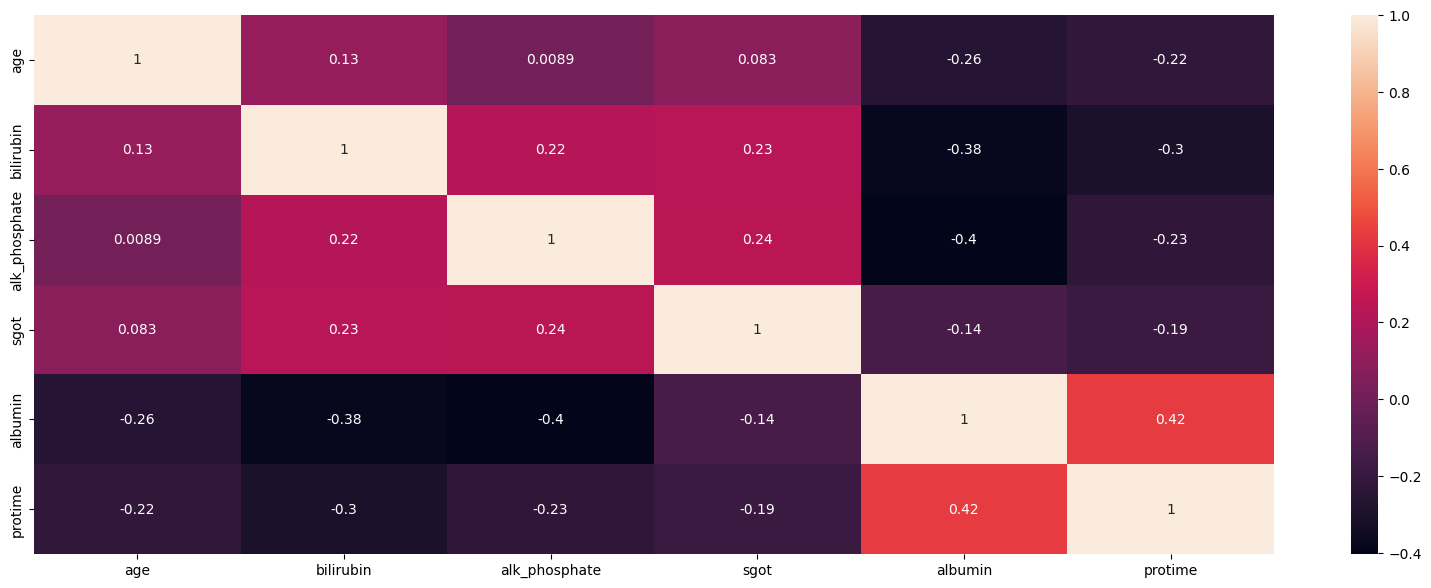

In [17]:
# df[numeric_columns].corr() #Tabular Show

sns.heatmap(df[numeric_columns].corr(), annot = True) #hitmap show
plt.rcParams['figure.figsize'] = (20,7)
plt.show() #error#

### Skewness handing

In [26]:
df[numeric_columns].skew()

,0
age,0.365294
bilirubin,2.891912
alk_phosphate,1.355307
sgot,3.178566
albumin,-0.121996
protime,0.022382


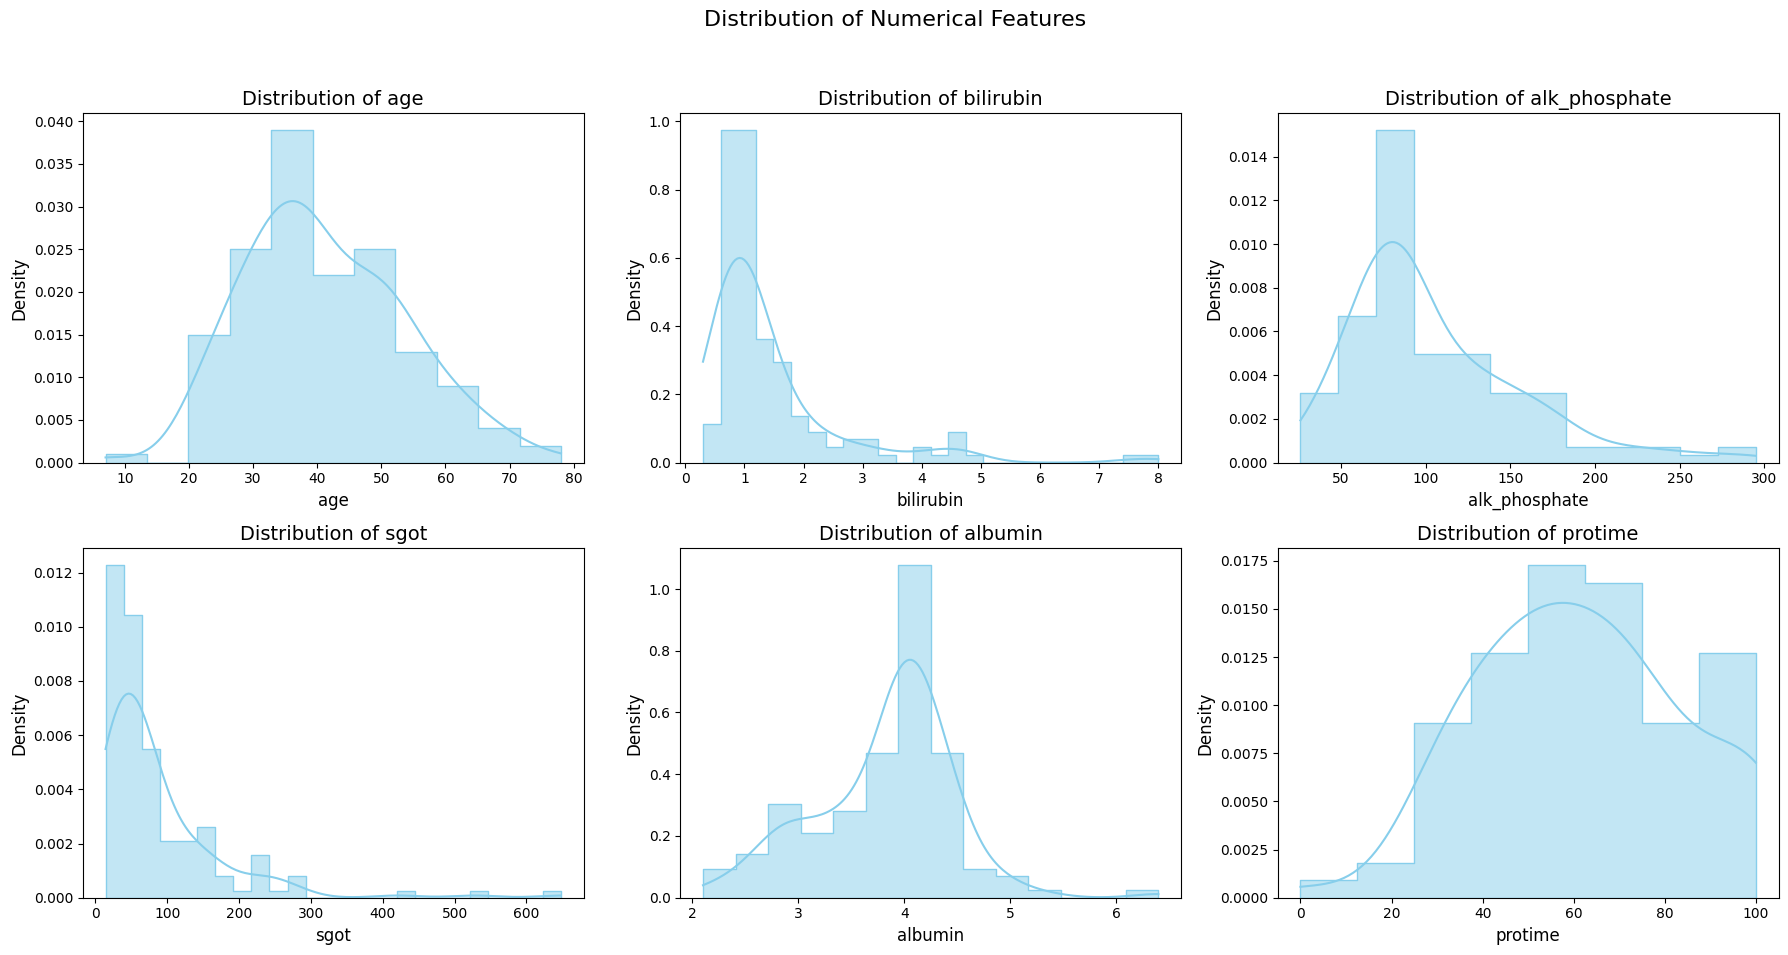

In [24]:

visualize_numerical_distributions(df)


Handling skewness for bilirubin (skewness: 2.89)
  Applied Square Root to bilirubin
Handling skewness for sgot (skewness: 3.18)
  Applied Square Root to sgot


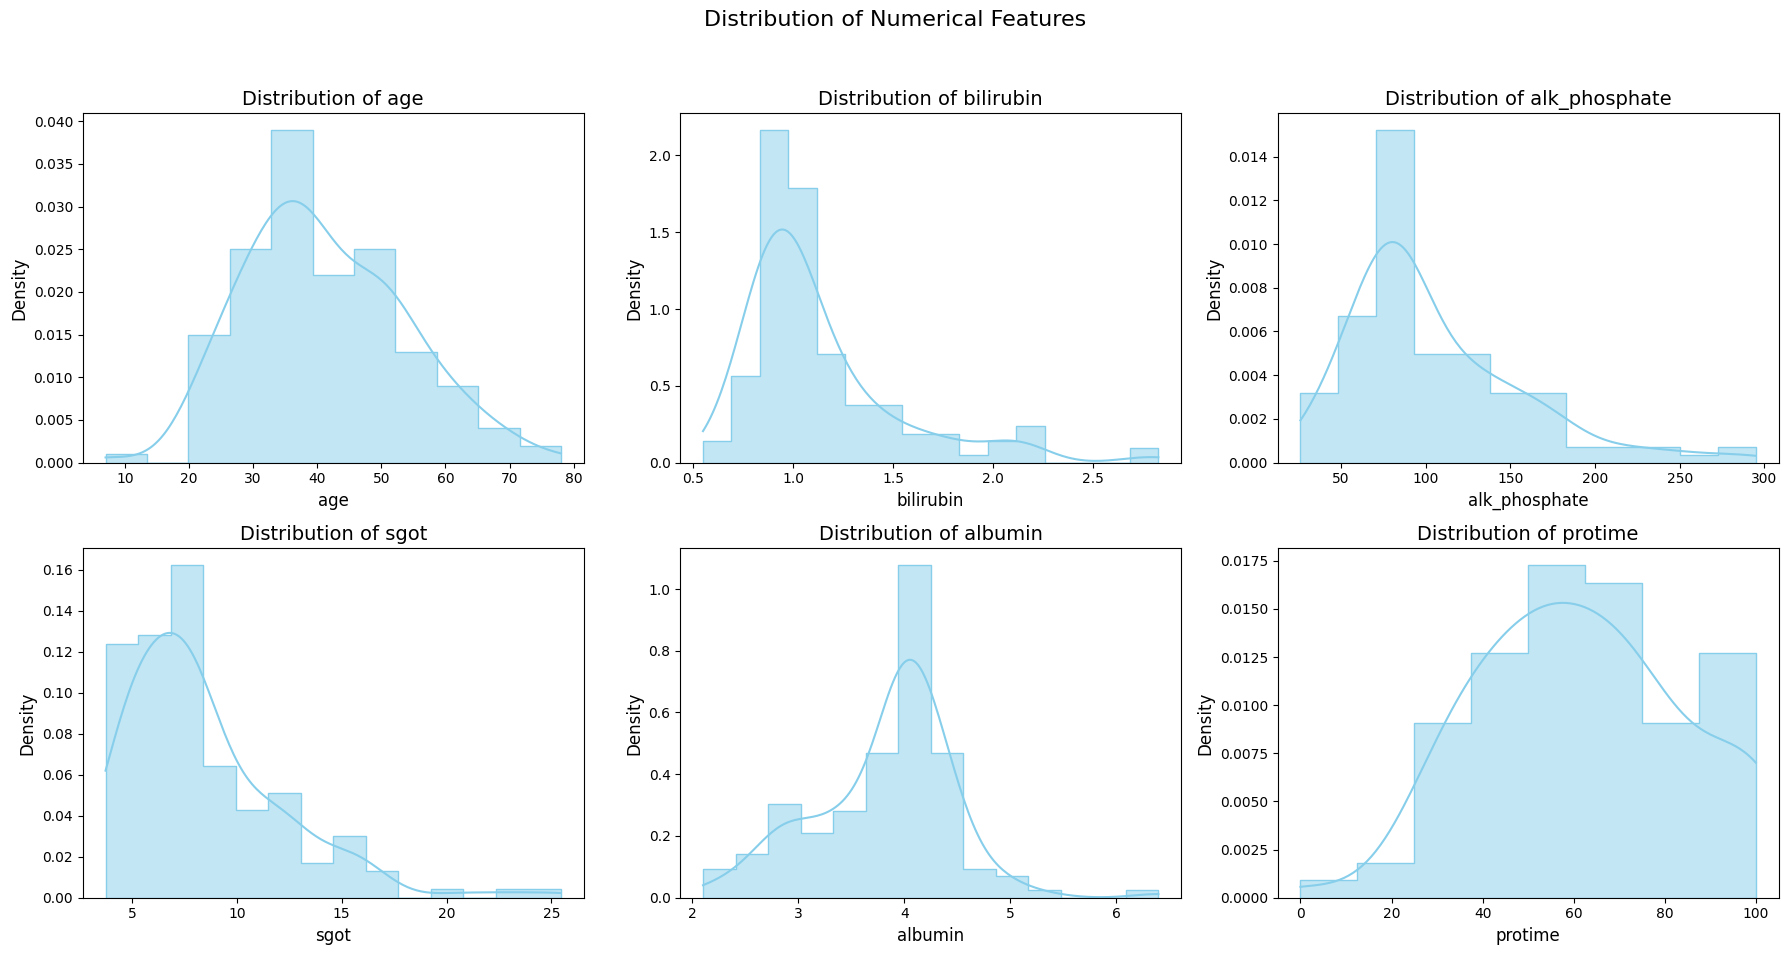

In [29]:
transformed_df, transformations = robust_skewness_handler(df)
visualize_numerical_distributions(transformed_df)